In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Exact INFERNO loss

Attempted reproduction INFERNO following TF1 & TF2 implementations with exact effect of nuisances being passed through model
Runs but doesn't reproduce paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler

import numpy as np
from abc import abstractmethod
from typing import Tuple, Optional

import torch.nn as nn
from torch import Tensor

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr

import torch.nn.functional as F
from torch import optim
import torch
from torch import autograd

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[8.8535e-14, 4.8634e-14, 1.4559e-17, 6.6387e-08, 7.5505e-01, 2.3809e-06,
          3.5060e-05, 1.4489e-13, 2.4489e-01, 2.0102e-05]]),
 tensor([[1.1882e-03, 1.0541e-03, 2.0802e-04, 1.7779e-02, 4.5822e-01, 3.6377e-02,
          6.2294e-02, 1.3113e-03, 3.6583e-01, 5.5735e-02]]),
 tensor([[0.0156, 0.0147, 0.0065, 0.0604, 0.3064, 0.0863, 0.1130, 0.0164, 0.2738,
          0.1069]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

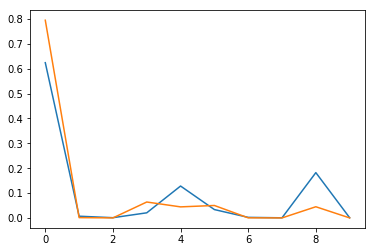

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed. 

This process includes the analytical effect of the nuisances, and their interdependence, since the augmented batch is passed through the model. This does, however, require that the effect of each nuisance on the input features is accurately parameterised.

Running cycle is:
1. on_train_begin: set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$.
1. for e in #epochs:
    1. for b in #batches:
        1. on_batch_begin: add relevant nuisances to incoming batch of inputs (as implemented in inheriting function)
        1. on_forwards_end:
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included since they're added to the input data and passed through the model)
            1. invert hessian , and set the diagonal element corresponding to $\mu$ as the loss value
        1. on_batch_end: zero gradient of alpha

In [ ]:
#export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model
    Runs but doesn't reproduce paper results; values are off and display strong changes between benchmarks
    Includes option to randomise params per batch, but results in worse performance'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)  #  Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = to_shape(self.wrapper.y_pred[self.b_mask])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [ ]:
#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1]
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(10)])

1: Train=497.4274514770508 Valid=408.34471923828124
2: Train=375.8917514038086 Valid=352.96046752929686
3: Train=342.02210723876954 Valid=333.2933459472656
4: Train=327.3842251586914 Valid=324.52184997558595
5: Train=318.8758660888672 Valid=318.0558508300781
6: Train=313.8660549926758 Valid=313.5749700927734
7: Train=309.63885620117185 Valid=309.1212939453125
8: Train=305.32783569335936 Valid=305.7711767578125
9: Train=302.4732925415039 Valid=302.87958068847655
10: Train=298.85242584228513 Valid=299.7166638183594
11: Train=296.5826773071289 Valid=296.7247940063477
12: Train=294.0609989929199 Valid=294.6117590332031
13: Train=291.8406834411621 Valid=292.249580078125
14: Train=289.6170373535156 Valid=290.0835070800781
15: Train=287.16737899780276 Valid=288.70758728027346
16: Train=284.69798736572267 Valid=286.48362518310546
17: Train=283.2212632751465 Valid=285.0945846557617
18: Train=281.6728303527832 Valid=283.68095458984374
19: Train=280.13597457885743 Valid=281.907412109375
20: Train

155: Train=240.90195709228516 Valid=246.39970642089844
156: Train=241.80960525512694 Valid=246.51336212158202
157: Train=241.4770443725586 Valid=246.05325866699218
158: Train=241.56426818847658 Valid=246.21314514160156
159: Train=241.2208657836914 Valid=246.12183288574218
160: Train=241.28684661865233 Valid=246.1421353149414
161: Train=241.71823608398438 Valid=246.20697937011718
162: Train=240.9805293273926 Valid=246.38898498535156
163: Train=240.79255264282227 Valid=246.12376403808594
164: Train=241.05218154907226 Valid=246.12708282470703
165: Train=240.9610353088379 Valid=246.11678955078125
166: Train=240.15436447143554 Valid=245.71550994873047
167: Train=240.8565545654297 Valid=245.82797607421875
168: Train=240.50476181030274 Valid=245.79729431152344
169: Train=240.6663609313965 Valid=245.32982177734374
170: Train=240.70801513671876 Valid=245.60380981445311
171: Train=240.25595932006837 Valid=245.45922607421875
172: Train=240.48304473876954 Valid=245.53577880859376
173: Train=239.94

In [ ]:
model.save('weights/Inferno_Test_exact_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_exact_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,8,1.0
2,8,1.0
3,7,1.0
4,1,1.0


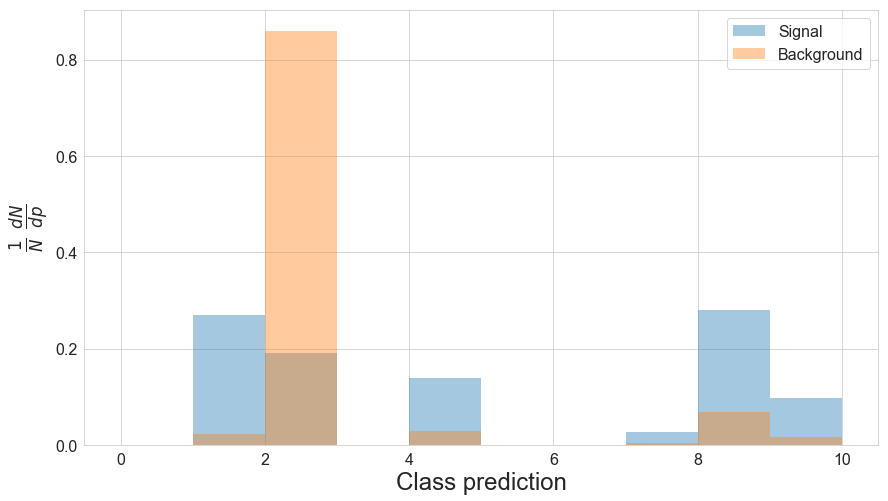

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,8,1.0,8
2,8,1.0,8
3,7,1.0,7
4,1,1.0,1


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([2.1000e-10, 3.5811e+01, 8.6994e+02, 2.1000e-10, 3.5915e+01, 2.1000e-10,
         2.1000e-10, 5.2118e+00, 8.1425e+01, 2.1695e+01]), tensor(1049.9999))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([19.16284943, 19.01592255, 18.87632751, 18.74163055, 18.61362839,
       18.49035454, 18.37256813, 18.26081085, 18.15450287, 18.05353737,
       17.95884132, 17.86787796, 17.78258896, 17.70331192, 17.62757301,
       17.55777168, 17.49285507, 17.43325806, 17.37740326, 17.32678032,
       17.28074265, 17.23931885, 17.20244026, 17.17100906, 17.14301682,
       17.11935997, 17.10055923, 17.08600044, 17.07518768, 17.06904221,
       17.06695366, 17.06899643, 17.0750618 , 17.08506584, 17.09955597,
       17.11742401, 17.13965416, 17.16518402, 17.19499779, 17.22851181,
       17.26527786, 17.30569267, 17.35066605, 17.39875793, 17.45084572,
       17.50551414, 17.56403732, 17.6265831 , 17.69244003, 17.76122665,
       17.83387566, 17.90975571, 17.98893738, 18.07085228, 18.15688324,
       18.24518013, 18.33710861, 18.43264008, 18.53121948, 18.63187408,
       18.73656845])

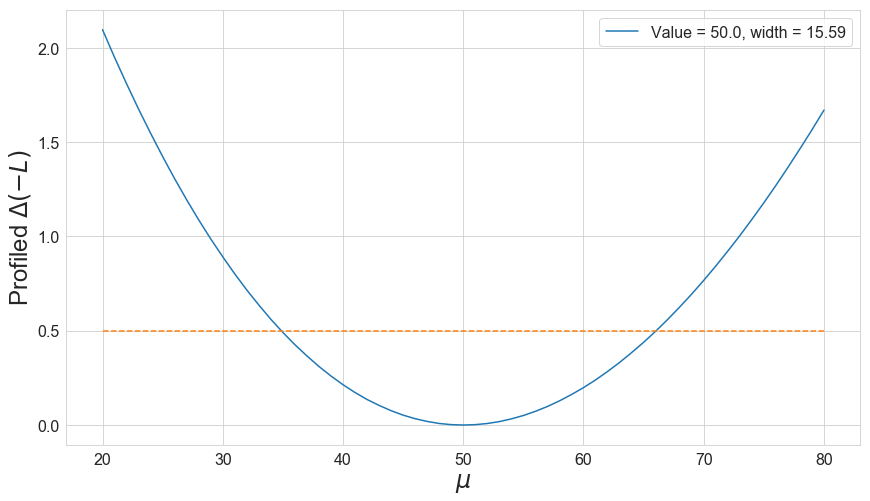

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,8,1.0,8,8,8,8,8,8,8,8,8,8,8
3,7,1.0,7,7,7,7,7,7,7,7,7,7,7
4,1,1.0,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999996,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999997,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999998,2,0.0,2,2,2,2,2,2,2,2,2,2,2


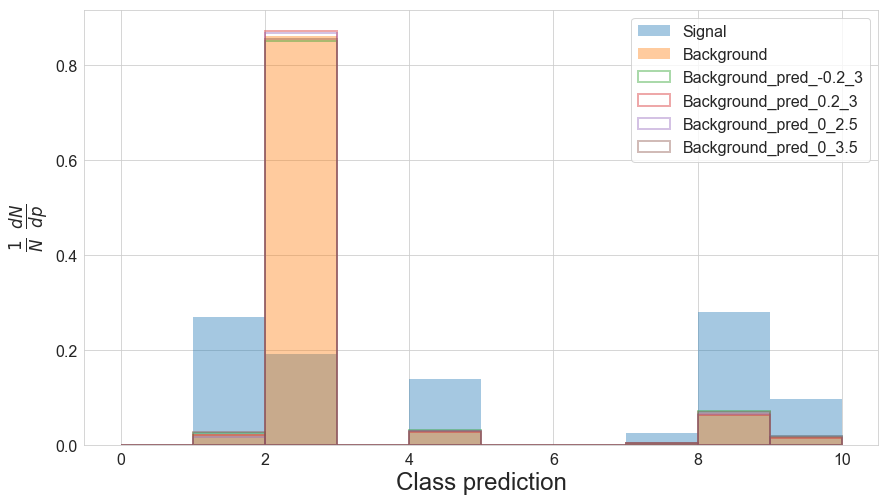

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0000e-13, 1.8804e-02, 8.5588e-01, 2.0000e-13, 3.2230e-02, 2.0000e-13,
        2.0000e-13, 4.3120e-03, 6.9124e-02, 1.9646e-02])
tensor([2.0000e-13, 2.4306e-02, 8.4963e-01, 2.0000e-13, 3.1946e-02, 2.0000e-13,
        2.0000e-13, 4.5280e-03, 7.0624e-02, 1.8966e-02])
tensor([2.0000e-13, 2.9898e-02, 8.4396e-01, 2.0000e-13, 3.1704e-02, 2.0000e-13,
        2.0000e-13, 4.6940e-03, 7.1394e-02, 1.8352e-02])
tensor([2.0000e-13, 1.6846e-02, 8.6668e-01, 2.0000e-13, 2.9298e-02, 2.0000e-13,
        2.0000e-13, 3.7160e-03, 6.5902e-02, 1.7556e-02])
tensor([2.0000e-13, 2.2348e-02, 8.6043e-01, 2.0000e-13, 2.9014e-02, 2.0000e-13,
        2.0000e-13, 3.9320e-03, 6.7402e-02, 1.6876e-02])
tensor([2.0000e-13, 2.7940e-02, 8.5476e-01, 2.0000e-13, 2.8772e-02, 2.0000e-13,
        2.0000e-13, 4.0980e-03, 6.8172e-02, 1.6262e-02])
tensor([2.0000e-13, 1.4866e-02, 8.7839e-01, 2.0000e-13, 2.6426e-02, 2.0000e-13,
        2.0000e-13, 3.2260e-03, 6.1496e-02, 1.5598e-02])
tensor([2.0000e-13, 2.0368e-02, 8.7213e-0

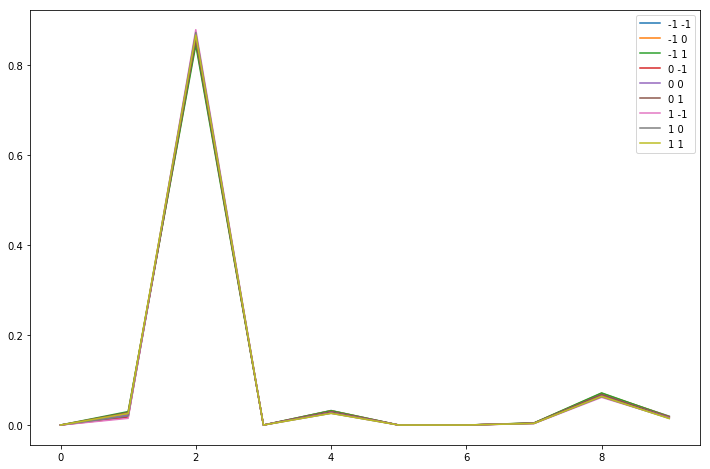

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.6521])
Linear regime: Mu 21.0, alpha tensor([-1.5954])
Linear regime: Mu 22.0, alpha tensor([-1.5387])
Linear regime: Mu 23.0, alpha tensor([-1.4822])
Linear regime: Mu 24.0, alpha tensor([-1.4258])
Linear regime: Mu 25.0, alpha tensor([-1.3696])
Linear regime: Mu 26.0, alpha tensor([-1.3134])
Linear regime: Mu 27.0, alpha tensor([-1.2574])
Linear regime: Mu 28.0, alpha tensor([-1.2015])
Linear regime: Mu 29.0, alpha tensor([-1.1458])
Linear regime: Mu 30.0, alpha tensor([-1.0901])
Linear regime: Mu 31.0, alpha tensor([-1.0346])
Linear regime: Mu 70.0, alpha tensor([1.0230])
Linear regime: Mu 71.0, alpha tensor([1.0734])
Linear regime: Mu 72.0, alpha tensor([1.1239])
Linear regime: Mu 73.0, alpha tensor([1.1743])
Linear regime: Mu 74.0, alpha tensor([1.2246])
Linear regime: Mu 75.0, alpha tensor([1.2748])
Linear regime: Mu 76.0, alpha tensor([1.3250])
Linear regime: Mu 77.0, alpha tensor([1.3752])
Linear regime: Mu 78.0, alpha tensor([1.4253])
L

In [ ]:
nll = to_np(nll)

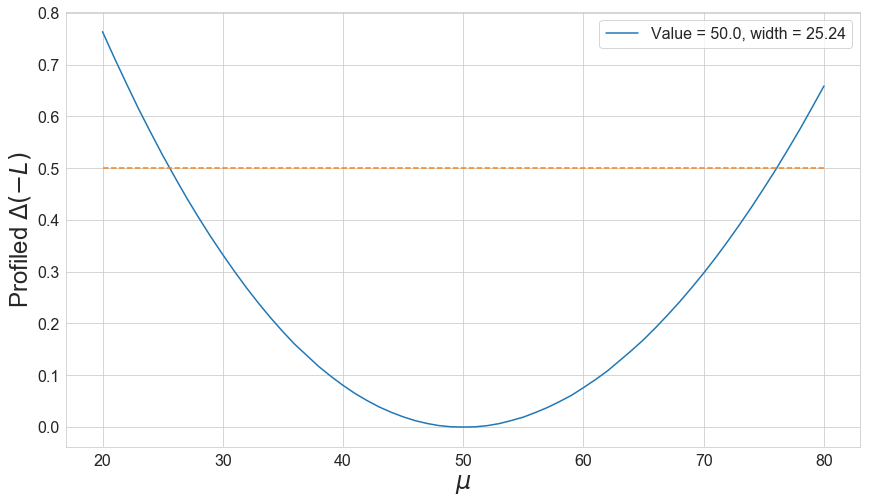

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.2791])
Linear regime: Mu 21.0, alpha tensor([1.2370])
Linear regime: Mu 22.0, alpha tensor([1.1949])
Linear regime: Mu 23.0, alpha tensor([1.1527])
Linear regime: Mu 24.0, alpha tensor([1.1105])
Linear regime: Mu 25.0, alpha tensor([1.0683])
Linear regime: Mu 26.0, alpha tensor([1.0259])
Linear regime: Mu 73.0, alpha tensor([-1.0263])
Linear regime: Mu 74.0, alpha tensor([-1.0712])
Linear regime: Mu 75.0, alpha tensor([-1.1161])
Linear regime: Mu 76.0, alpha tensor([-1.1610])
Linear regime: Mu 77.0, alpha tensor([-1.2060])
Linear regime: Mu 78.0, alpha tensor([-1.2510])
Linear regime: Mu 79.0, alpha tensor([-1.2960])
Linear regime: Mu 80.0, alpha tensor([-1.3410])


In [ ]:
nll = to_np(nll)

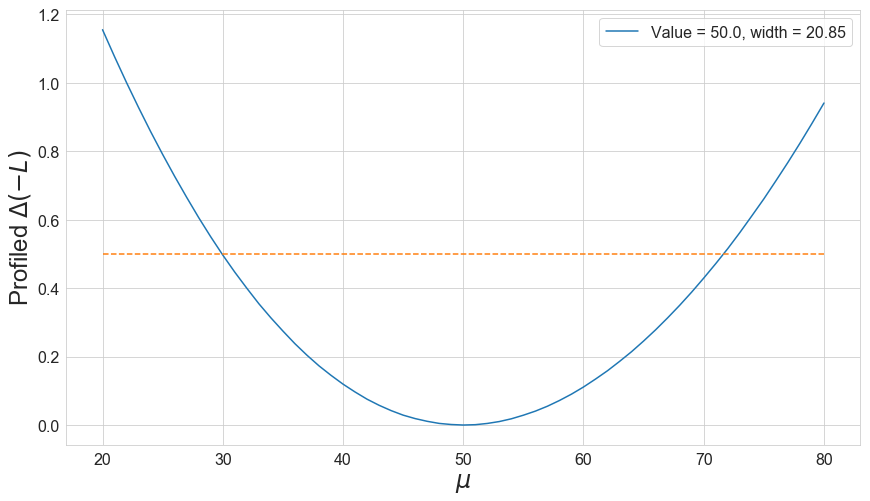

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.2824,  0.8190])
Linear regime: Mu 21.0, alpha tensor([-1.2390,  0.7922])
Linear regime: Mu 22.0, alpha tensor([-1.1956,  0.7654])
Linear regime: Mu 23.0, alpha tensor([-1.1523,  0.7385])
Linear regime: Mu 24.0, alpha tensor([-1.1091,  0.7116])
Linear regime: Mu 25.0, alpha tensor([-1.0658,  0.6846])
Linear regime: Mu 26.0, alpha tensor([-1.0226,  0.6576])
Linear regime: Mu 75.0, alpha tensor([ 1.0131, -0.6752])
Linear regime: Mu 76.0, alpha tensor([ 1.0532, -0.7021])
Linear regime: Mu 77.0, alpha tensor([ 1.0933, -0.7290])
Linear regime: Mu 78.0, alpha tensor([ 1.1334, -0.7559])
Linear regime: Mu 79.0, alpha tensor([ 1.1735, -0.7827])
Linear regime: Mu 80.0, alpha tensor([ 1.2135, -0.8096])


In [ ]:
nll = to_np(nll)

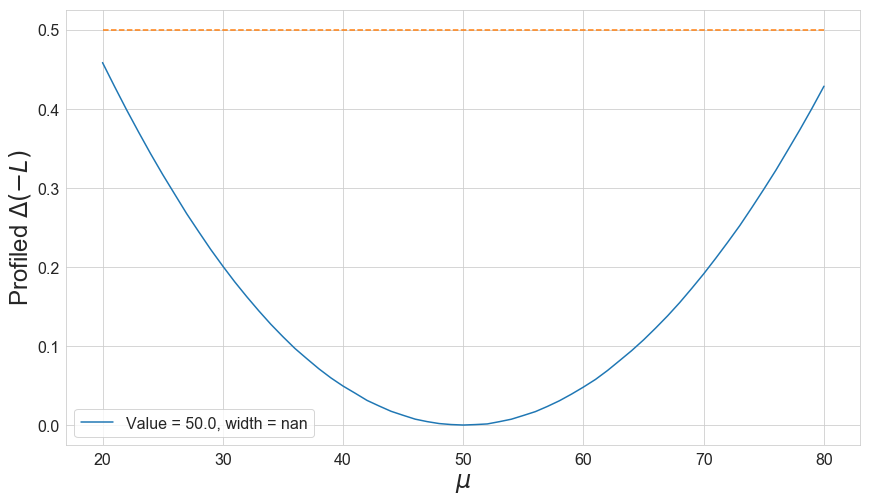

In [ ]:
plot_likelihood(nll-nll.min())

In [ ]:
b_shapes

OrderedDict([('f_b_nom',
              tensor([2.0000e-13, 2.2348e-02, 8.6043e-01, 2.0000e-13, 2.9014e-02, 2.0000e-13,
                      2.0000e-13, 3.9320e-03, 6.7402e-02, 1.6876e-02])),
             ('f_b_up',
              tensor([[2.0000e-13, 2.0368e-02, 8.7213e-01, 2.0000e-13, 2.6142e-02, 2.0000e-13,
                       2.0000e-13, 3.4420e-03, 6.2996e-02, 1.4918e-02],
                      [2.0000e-13, 2.7940e-02, 8.5476e-01, 2.0000e-13, 2.8772e-02, 2.0000e-13,
                       2.0000e-13, 4.0980e-03, 6.8172e-02, 1.6262e-02]])),
             ('f_b_dw',
              tensor([[2.0000e-13, 2.4306e-02, 8.4963e-01, 2.0000e-13, 3.1946e-02, 2.0000e-13,
                       2.0000e-13, 4.5280e-03, 7.0624e-02, 1.8966e-02],
                      [2.0000e-13, 1.6846e-02, 8.6668e-01, 2.0000e-13, 2.9298e-02, 2.0000e-13,
                       2.0000e-13, 3.7160e-03, 6.5902e-02, 1.7556e-02]]))])

In [ ]:
f_s

tensor([2.0000e-13, 2.6925e-01, 1.9029e-01, 2.0000e-13, 1.3802e-01, 2.0000e-13,
        2.0000e-13, 2.5596e-02, 2.8045e-01, 9.6386e-02])